In [117]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import math

warnings.simplefilter(action='ignore', category=FutureWarning)

In [118]:
def strategia_media_pesata_forzata_bidirezionale(btc_data,
                      liquidità_iniziale,
                      bitcoin_iniziali,
                      percentuale_sbilanciamento_acquisti, 
                      percentuale_sbilanciamento_vendite,
                      percentuale_primo_acquisto, 
                      percentuale_prima_vendita, 
                      percentuale_commissione_acquisti, 
                      percentuale_commissione_vendite,
                      acquisto_minimo, 
                      vendita_minima,
                      vendi_pure,
                      compra_pure,
                      soglia_minima_vendita):
    
    # Inizializzazione delle variabili
    liquidità = liquidità_iniziale
    bitcoin = bitcoin_iniziali
    valore_portafoglio = []
    transazioni = []

    # Variabili di controllo
    ultima_azione = None
    ultimo_prezzo_acquisto = 0
    ultimo_prezzo_vendita = 0
    somme_acquisto = 0
    somme_vendita = 0
    pesi_acquisto = 0
    pesi_vendita = 0

    # Nuove variabili per il calcolo del prezzo medio pesato
    acquisti_consecutivi = []
    prezzo_medio_pesato_acquisti = 0

    for i in range(1, len(btc_data)):
        azione = "-"
        # ultima_azione = '-'
        quantità_euro = 0
        quantità_bitcoin = 0
        prezzo_oggi = btc_data['Price'].iloc[i]
        prezzo_ieri = btc_data['Price'].iloc[i-1]
        data = btc_data['Timestamp'].iloc[i]

        liquidità_precedente = liquidità
        bitcoin_precedenti = bitcoin

        def esegui_acquisto():
            nonlocal quantità_euro, quantità_bitcoin, liquidità, bitcoin, azione, ultima_azione, ultimo_prezzo_acquisto, somme_acquisto, pesi_acquisto, somme_vendita, pesi_vendita, acquisti_consecutivi, prezzo_medio_pesato_acquisti
            if quantità_euro >= acquisto_minimo and quantità_euro != 0:
                if quantità_euro > liquidità and compra_pure:
                    quantità_euro = liquidità
                    quantità_bitcoin = (quantità_euro / prezzo_oggi) * (1 - percentuale_commissione_acquisti)
                    bitcoin += quantità_bitcoin
                    liquidità -= quantità_euro
                    azione = "acquisto"
                    ultima_azione = "acquisto"
                    ultimo_prezzo_acquisto = prezzo_oggi
                    somme_acquisto += prezzo_oggi * quantità_euro
                    pesi_acquisto += quantità_euro
                    acquisti_consecutivi.append((prezzo_oggi, quantità_euro))
                    prezzo_medio_pesato_acquisti = sum(p*q for p, q in acquisti_consecutivi) / sum(q for _, q in acquisti_consecutivi)
                    somme_vendita = 0
                    pesi_vendita = 0
                elif quantità_euro <= liquidità:
                    quantità_bitcoin = (quantità_euro / prezzo_oggi) * (1 - percentuale_commissione_acquisti)
                    bitcoin += quantità_bitcoin
                    liquidità -= quantità_euro
                    azione = "acquisto"
                    ultima_azione = "acquisto"
                    ultimo_prezzo_acquisto = prezzo_oggi
                    somme_acquisto += prezzo_oggi * quantità_euro
                    pesi_acquisto += quantità_euro
                    acquisti_consecutivi.append((prezzo_oggi, quantità_euro))
                    prezzo_medio_pesato_acquisti = sum(p*q for p, q in acquisti_consecutivi) / sum(q for _, q in acquisti_consecutivi)
                    somme_vendita = 0
                    pesi_vendita = 0
            #     else:
            #         azione = '-'
            # else:
            #     azione = '-'

        def esegui_vendita():
            nonlocal quantità_euro, quantità_bitcoin, liquidità, bitcoin, azione, ultima_azione, ultimo_prezzo_vendita, somme_vendita, pesi_vendita, somme_acquisto, pesi_acquisto, acquisti_consecutivi, prezzo_medio_pesato_acquisti
            if quantità_euro >= vendita_minima and quantità_euro != 0:
                if quantità_bitcoin > bitcoin and vendi_pure and prezzo_oggi >= prezzo_medio_pesato_acquisti * (1 + soglia_minima_vendita):
                    quantità_bitcoin = bitcoin
                    quantità_euro = quantità_bitcoin * prezzo_oggi * (1 - percentuale_commissione_vendite)
                    bitcoin -= quantità_bitcoin
                    liquidità += quantità_euro
                    azione = "vendita"
                    ultima_azione = "vendita"
                    ultimo_prezzo_vendita = prezzo_oggi
                    somme_vendita += prezzo_oggi * quantità_euro
                    pesi_vendita += quantità_euro
                    acquisti_consecutivi = []
                    somme_acquisto = 0
                    pesi_acquisto = 0
                elif quantità_bitcoin <= bitcoin and prezzo_oggi >= prezzo_medio_pesato_acquisti * (1 + soglia_minima_vendita):
                    if quantità_euro > 0 and quantità_bitcoin > 0:
                        bitcoin -= quantità_bitcoin
                        liquidità += quantità_euro
                        azione = "vendita"
                        ultima_azione = "vendita"
                        ultimo_prezzo_vendita = prezzo_oggi
                        somme_vendita += prezzo_oggi * quantità_euro
                        pesi_vendita += quantità_euro
                        acquisti_consecutivi = []
                        somme_acquisto = 0
                        pesi_acquisto = 0
            #         else:
            #             azione = '-'
            #     else:
            #         azione = '-'
            # else:
            #     azione = '-'

        if ultima_azione is None:  # Caso del primo giorno
            if prezzo_oggi < prezzo_ieri:  # Il prezzo è sceso
                quantità_euro = liquidità * percentuale_primo_acquisto
                esegui_acquisto()
            elif prezzo_oggi > prezzo_ieri:  # Il prezzo è salito
                quantità_bitcoin = bitcoin * percentuale_prima_vendita
                quantità_euro = quantità_bitcoin * prezzo_oggi
                esegui_vendita()
            else:
                azione = '-'

        else:  # Dopo il primo giorno
            if ultima_azione == "acquisto" and prezzo_oggi < ultimo_prezzo_acquisto:
                A = percentuale_sbilanciamento_acquisti * prezzo_oggi + (1 - percentuale_sbilanciamento_acquisti) * ultimo_prezzo_acquisto
                quantità_euro = (somme_acquisto - A * pesi_acquisto) / (A - prezzo_oggi)
                esegui_acquisto()
            elif ultima_azione == "vendita" and prezzo_oggi > ultimo_prezzo_vendita:
                A = percentuale_sbilanciamento_vendite * prezzo_oggi + (1 - percentuale_sbilanciamento_vendite) * ultimo_prezzo_vendita
                quantità_euro = (somme_vendita - A * pesi_vendita) / (A - prezzo_oggi)
                quantità_bitcoin = (quantità_euro / prezzo_oggi)
                esegui_vendita()
            elif ultima_azione == "acquisto" and prezzo_oggi > ultimo_prezzo_acquisto:
                # Cambio di direzione: si vende dopo un acquisto
                quantità_bitcoin = percentuale_prima_vendita * bitcoin
                quantità_euro = quantità_bitcoin * prezzo_oggi
                esegui_vendita()
            elif ultima_azione == "vendita" and prezzo_oggi < ultimo_prezzo_vendita:
                # Cambio di direzione: si compra dopo una vendita
                quantità_euro = percentuale_primo_acquisto * liquidità
                esegui_acquisto()

        valore_totale = liquidità + bitcoin * prezzo_oggi
        valore_portafoglio.append(valore_totale)
        
        transazioni.append({
            'data': data,
            'prezzo': prezzo_oggi,
            'azione': azione,
            'ultima azione': ultima_azione,
            'percentuale_liquidità_usata': round((quantità_euro / liquidità_precedente) * 100, 2) if azione == "acquisto" and liquidità_precedente != 0 else 0,
            'percentuale_token_venduti': round((quantità_bitcoin / bitcoin_precedenti) * 100, 2) if azione == "vendita" and bitcoin_precedenti != 0 else 0,
            'quantità_euro': quantità_euro,
            'quantità_bitcoin': quantità_bitcoin,
            'liquidità_posseduta': liquidità,
            'bitcoin_posseduti': bitcoin,
            'valore_totale_portafoglio': valore_totale
        })

    return pd.DataFrame(transazioni)

In [119]:
# Funzione per calcolare la dimensione dei punti nel grafico
def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
    return min_size + (max_size - min_size) * (quantita / max_quantita)

In [120]:
# Funzione per plottare il grafico delle transazioni
def plot_transazioni(dati, transazioni, etichette=True):
    acquisti = transazioni[transazioni['azione'] == 'acquisto']
    vendite = transazioni[transazioni['azione'] == 'vendita']

    # Calcolo delle dimensioni dei punti
    max_acquisto = acquisti['quantità_euro'].max() if not acquisti.empty else 0
    max_vendita = vendite['quantità_euro'].max() if not vendite.empty else 0

    dimensioni_acquisti = acquisti['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_acquisto)) if max_acquisto > 0 else []
    dimensioni_vendite = vendite['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_vendita)) if max_vendita > 0 else []

    # Creazione del grafico
    plt.figure(figsize=(20, 14))
    plt.grid()
    plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
    if not acquisti.empty:
        plt.scatter(acquisti['data'], acquisti['prezzo'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
        if etichette:
            for i, row in acquisti.iterrows():
                plt.text(row['data'], row['prezzo'], f"+{row['quantità_euro']:.2f} €", 
                         color='black', ha='center', va='bottom')
    if not vendite.empty:
        plt.scatter(vendite['data'], vendite['prezzo'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
        if etichette:
            for i, row in vendite.iterrows():
                plt.text(row['data'], row['prezzo'], f"-{row['quantità_euro']:.2f} €", 
                         color='black', ha='center', va='top')

    plt.xlabel('Data')
    plt.ylabel('Prezzo')
    plt.title('Andamento dei prezzi e transazioni')
    plt.legend()
    plt.show()

### Lettura dati

In [121]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [122]:
# dati = pd.read_csv('Bitcoin (€) da yfinance dal 06-05-2022 alle 21 al 05-05-2024 alle 19 con granularità oraria.csv')
# dati = dati[['Datetime', 'Close']]
# dati = dati.rename(columns = {'Datetime':'Timestamp', 'Close': 'Price'})
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
# dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d %H')
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d %H')
# dati

In [123]:
data_inizio = '2020-02-29'
data_fine = '2020-09-01'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2020-02-29,7798.025879
1,2020-03-01,7748.164551
2,2020-03-02,7959.358398
3,2020-03-03,7862.485352
4,2020-03-04,7861.055176
...,...,...
181,2020-08-28,9695.468750
182,2020-08-29,9664.351562
183,2020-08-30,9824.922852
184,2020-08-31,9785.023438


In [124]:
# data_inizio = '2023-06-01 00'
# data_fine = '2023-12-01 00'
# indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
# indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
# dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
# dati

### Eventuale cambio dati

In [125]:
def calcola_prezzo(t):
    return dati['Price'][t] #1000 - t + 100 * math.sin(2*math.pi * t / 4)

In [126]:
dati['Price'] = dati.index.map(calcola_prezzo)
dati

,Timestamp,Price
0,2020-02-29,7798.025879
1,2020-03-01,7748.164551
2,2020-03-02,7959.358398
3,2020-03-03,7862.485352
4,2020-03-04,7861.055176
...,...,...
181,2020-08-28,9695.468750
182,2020-08-29,9664.351562
183,2020-08-30,9824.922852
184,2020-08-31,9785.023438


In [127]:
percentuale_sbilanciamento_acquisti=0.1
percentuale_sbilanciamento_vendite=0.1
percentuale_primo_acquisto=0.1
percentuale_prima_vendita=0.1
vendi_pure=True
compra_pure=True
soglia_minima_vendita = 0

liquidità_iniziale=1000
bitcoin_iniziali=0
percentuale_commissione_acquisti=0.001
percentuale_commissione_vendite=0.001
acquisto_minimo=0
vendita_minima=0

# Applica la strategia
df_transazioni = strategia_media_pesata_forzata_bidirezionale(dati, 
                      liquidità_iniziale, 
                      bitcoin_iniziali, 
                      percentuale_sbilanciamento_acquisti, 
                      percentuale_sbilanciamento_vendite,
                      percentuale_primo_acquisto, 
                      percentuale_prima_vendita,
                      percentuale_commissione_acquisti, 
                      percentuale_commissione_vendite,
                      acquisto_minimo,
                      vendita_minima,
                      vendi_pure,
                      compra_pure,
                      soglia_minima_vendita)

# Visualizza il valore del portafoglio nel tempo
df_transazioni

,data,prezzo,azione,ultima azione,percentuale_liquidità_usata,percentuale_token_venduti,quantità_euro,quantità_bitcoin,liquidità_posseduta,bitcoin_posseduti,valore_totale_portafoglio
0,2020-03-01,7748.164551,acquisto,acquisto,10.00,0.0,100.000000,0.012893,900.000000,0.012893,999.900000
1,2020-03-02,7959.358398,vendita,vendita,0.00,10.0,10.262300,0.001289,910.262300,0.011604,1002.623002
2,2020-03-03,7862.485352,acquisto,acquisto,10.00,0.0,91.026230,0.011566,819.236070,0.023170,1001.407857
3,2020-03-04,7861.055176,acquisto,acquisto,1.23,0.0,10.114026,0.001285,809.122045,0.024455,1001.364606
4,2020-03-05,8089.786133,vendita,vendita,0.00,10.0,19.783619,0.002446,828.905664,0.022010,1006.958235
...,...,...,...,...,...,...,...,...,...,...,...
180,2020-08-28,9695.468750,vendita,vendita,0.00,10.0,67.758088,0.006989,600.651864,0.062898,1210.474657
181,2020-08-29,9664.351562,acquisto,acquisto,10.00,0.0,60.065186,0.006209,540.586677,0.069107,1208.457392
182,2020-08-30,9824.922852,vendita,vendita,0.00,10.0,67.896725,0.006911,608.483403,0.062196,1219.553932
183,2020-08-31,9785.023438,acquisto,acquisto,10.00,0.0,60.848340,0.006212,547.635063,0.068408,1217.011501


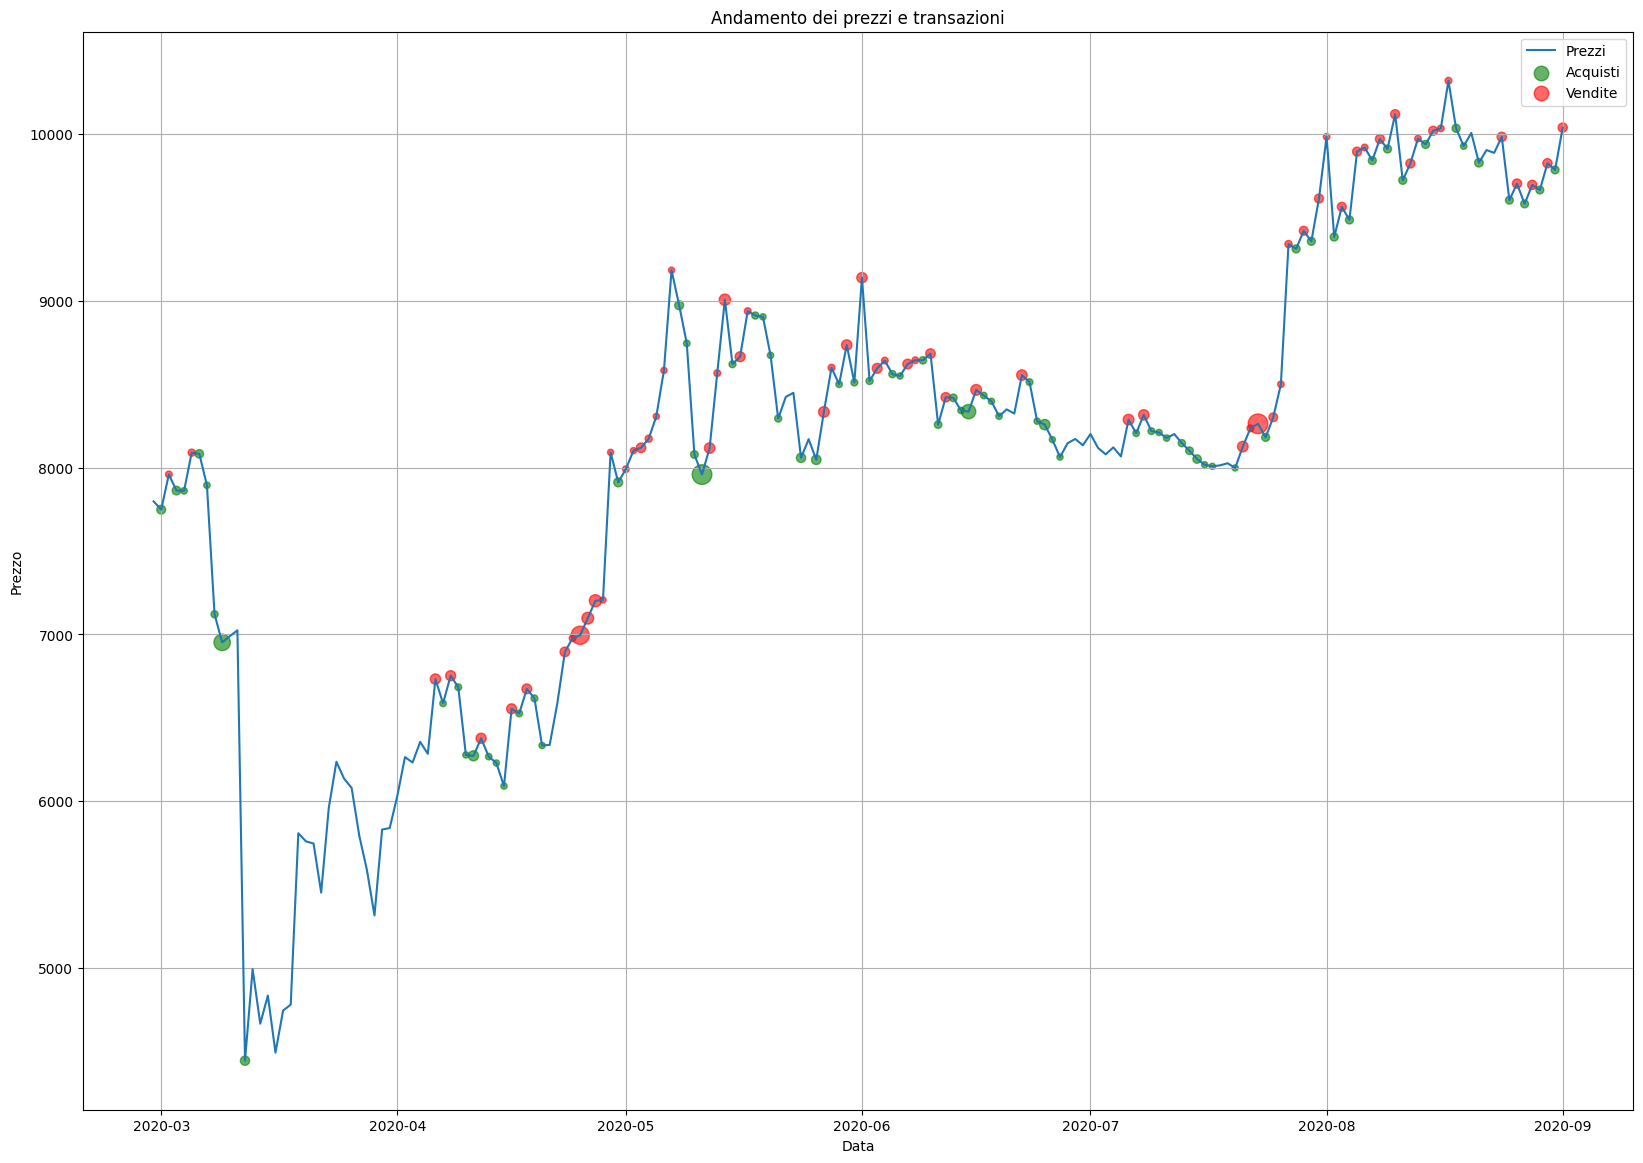

In [128]:
# Plotta il grafico delle transazioni
plot_transazioni(dati, df_transazioni, etichette=False)

In [129]:
df_transazioni[:60]

,data,prezzo,azione,ultima azione,percentuale_liquidità_usata,percentuale_token_venduti,quantità_euro,quantità_bitcoin,liquidità_posseduta,bitcoin_posseduti,valore_totale_portafoglio
0,2020-03-01,7748.164551,acquisto,acquisto,10.00,0.00,100.000000,0.012893,900.000000,0.012893,999.900000
1,2020-03-02,7959.358398,vendita,vendita,0.00,10.00,10.262300,0.001289,910.262300,0.011604,1002.623002
2,2020-03-03,7862.485352,acquisto,acquisto,10.00,0.00,91.026230,0.011566,819.236070,0.023170,1001.407857
3,2020-03-04,7861.055176,acquisto,acquisto,1.23,0.00,10.114026,0.001285,809.122045,0.024455,1001.364606
4,2020-03-05,8089.786133,vendita,vendita,0.00,10.00,19.783619,0.002446,828.905664,0.022010,1006.958235
5,2020-03-06,8082.739746,acquisto,acquisto,10.00,0.00,82.890566,0.010245,746.015097,0.032255,1006.720257
6,2020-03-07,7894.343750,acquisto,acquisto,1.23,0.00,9.210063,0.001165,736.805034,0.033420,1000.634418
7,2020-03-08,7121.034180,acquisto,acquisto,4.43,0.00,32.671235,0.004583,704.133800,0.038003,974.757700
8,2020-03-09,6952.206055,acquisto,acquisto,83.13,0.00,585.375405,0.084116,118.758394,0.122119,967.756273
9,2020-03-10,6989.210938,-,acquisto,0.00,0.00,85.351689,0.012212,118.758394,0.122119,972.275280


In [130]:
def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [131]:
rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(liquidità_iniziale, bitcoin_iniziali, dati['Price'], acquisto_minimo, vendita_minima, percentuale_commissione_acquisti, percentuale_commissione_vendite)
print('Rendimento ideale:', rendimento_ideale)
print('Portafoglio finale ideale in euro:', portafoglio_finale_ideale)

Rendimento ideale: 10.014867303574043
Portafoglio finale ideale in euro: 10014.867303574043


In [132]:
valore_iniziale = liquidità_iniziale + bitcoin_iniziali * dati['Price'][0]
valore_finale = df_transazioni['liquidità_posseduta'].iloc[-1] + df_transazioni['bitcoin_posseduti'].iloc[-1] * dati['Price'].iloc[-1]
rendimento = valore_finale / valore_iniziale

In [133]:
print(f"Rendimento del portafoglio: {rendimento}")
print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale *100, 2)}%')
print(f"Valore finale del portafoglio in euro: {df_transazioni['liquidità_posseduta'].iloc[-1] + df_transazioni['bitcoin_posseduti'].iloc[-1] * dati['Price'].iloc[-1]}")

Rendimento del portafoglio: 1.2343557344429488
Punteggio rendimento: 12.33%
Valore finale del portafoglio in euro: 1234.3557344429487
